## Vancouver Crime Data Analysis

This notebook is just for cleaning and creating dataframes for different visualizations.
Data was directly downloaded from the VPD crime-statistics website, using the GeoDash tool.
Geographic data (GEOJSON, polygons etc...) downloaded from City of Vancouver Open Data Portal

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import geopandas as geo

from mpl_toolkits.mplot3d import Axes3D

from datetime import datetime

## ETL - Extract, Cleaning and Creating Dataframes
1. Load data
2. Clean up column names, remove unncessary columns. Create any new columns as needed
3. Clean data by removing null/NaN values, filter out any data obfuscated for privacy. 

In [2]:
vancrime = pd.read_csv('crimedata_csv_AllNeighbourhoods_AllYears/crimedata_csv_AllNeighbourhoods_AllYears.csv')
vancrime.head(3)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.0000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.9648,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491004.8164,5.459177e+06


In [3]:
#vancrime.info()
vancrime.TYPE.value_counts()

TYPE
Theft from Vehicle                                        249982
Other Theft                                               234742
Mischief                                                  113416
Offence Against a Person                                   81209
Break and Enter Residential/Other                          73620
Break and Enter Commercial                                 49327
Theft of Vehicle                                           45622
Theft of Bicycle                                           38283
Vehicle Collision or Pedestrian Struck (with Injury)       16614
Vehicle Collision or Pedestrian Struck (with Fatality)       415
Homicide                                                     329
Name: count, dtype: int64

In [4]:
vancrime.rename(columns={'TYPE': 'crime_type', 'X': 'longitude','Y': 'latitude'}, inplace=True)

In [5]:
# Dont need hour and minute (for now), also hundred_block is a meaningless label for non-govertmental or non-police purposes. 
vancrime = vancrime.drop(['HOUR','MINUTE','HUNDRED_BLOCK'],axis=1)

In [6]:
vancrime.columns = vancrime.columns.str.lower()
vancrime.head(2)

,crime_type,year,month,day,neighbourhood,longitude,latitude
0,Break and Enter Commercial,2012,12,14,Oakridge,491285.0000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,Fairview,490612.9648,5.457110e+06


In [7]:
# create a new column for easier reading and typing - only for working purposes as its easier to type
vancrime['type_min']=vancrime['crime_type']
vancrime.update(vancrime['type_min'].replace({'Break and Enter Commercial': 'BnE_com','Break and Enter Residential/Other':'BnE_res','Offence Against a Person':'oap','Other Theft':'theft_other','Theft from Vehicle':'theft_fr_vehicle','Theft of Bicycle':'theft_obike','Theft of Vehicle': 'theft_ovehicle','Vehicle Collision or Pedestrian Struck (with Fatality)': 'carcrash_fatal','Vehicle Collision or Pedestrian Struck (with Injury)':'carcrash_injury'}))
#vancrime.head(2)
vancrime.type_min.unique()

array(['BnE_com', 'BnE_res', 'Homicide', 'Mischief', 'oap', 'theft_other',
       'theft_fr_vehicle', 'theft_obike', 'theft_ovehicle',
       'carcrash_fatal', 'carcrash_injury'], dtype=object)

In [8]:
# Now we can clean nan and null values
vancrime[vancrime.duplicated(keep=False)]

,crime_type,year,month,day,neighbourhood,longitude,latitude,type_min
109,Break and Enter Commercial,2012,4,1,West End,490227.2225,5.458210e+06,BnE_com
110,Break and Enter Commercial,2012,4,1,West End,490227.2225,5.458210e+06,BnE_com
439,Break and Enter Commercial,2019,6,23,Central Business District,491492.0426,5.459540e+06,BnE_com
440,Break and Enter Commercial,2019,6,23,Central Business District,491492.0426,5.459540e+06,BnE_com
477,Break and Enter Commercial,2020,12,7,Central Business District,491493.3778,5.459542e+06,BnE_com
...,...,...,...,...,...,...,...,...
900511,Vehicle Collision or Pedestrian Struck (with I...,2022,10,26,Marpole,490497.0000,5.450214e+06,carcrash_injury
902701,Vehicle Collision or Pedestrian Struck (with I...,2015,10,4,Fairview,489918.0000,5.456767e+06,carcrash_injury
903007,Vehicle Collision or Pedestrian Struck (with I...,2021,11,6,Arbutus Ridge,488863.0000,5.455441e+06,carcrash_injury
903008,Vehicle Collision or Pedestrian Struck (with I...,2021,11,6,Arbutus Ridge,488863.0000,5.455441e+06,carcrash_injury


In [9]:
crime_clean = vancrime.drop_duplicates(keep='first')

In [10]:
# Now we can just check all the columns for what type of data they contain.
# This will show a 'nan' value in neighbourhoods which needs to be filtered out.
for col in crime_clean:
    print(crime_clean[col].unique())

['Break and Enter Commercial' 'Break and Enter Residential/Other'
 'Homicide' 'Mischief' 'Offence Against a Person' 'Other Theft'
 'Theft from Vehicle' 'Theft of Bicycle' 'Theft of Vehicle'
 'Vehicle Collision or Pedestrian Struck (with Fatality)'
 'Vehicle Collision or Pedestrian Struck (with Injury)']
[2012 2019 2021 2014 2020 2022 2005 2006 2009 2013 2017 2018 2007 2010
 2023 2004 2003 2011 2015 2016 2008 2024]
[12  3  8  4  7 11  1  5  6  9  2 10]
[14  7 27 26  8 28 21  5  1 17  3  2 13 15  6 22 19 24 25 18  4 16 29  9
 10 12 31 11 23 30 20]
['Oakridge' 'Fairview' 'West End' 'Shaughnessy'
 'Central Business District' 'Hastings-Sunrise' 'Strathcona'
 'Grandview-Woodland' 'Kitsilano' 'Mount Pleasant'
 'Kensington-Cedar Cottage' 'Sunset' 'Stanley Park' 'Marpole'
 'West Point Grey' 'Victoria-Fraserview' 'Kerrisdale' 'Riley Park'
 'Arbutus Ridge' 'Renfrew-Collingwood' 'Killarney' 'Dunbar-Southlands'
 'South Cambie' 'Musqueam' nan]
[491285.     490612.9648 491004.8164 ... 488723.     491

In [11]:
nbhood_nan_count = crime_clean['neighbourhood'].isna().sum()
total_entries = len(crime_clean.index)
print('Number NaN rows:',nbhood_nan_count, 'and', 'Total rows:',total_entries)
print('Is it statistically relevant? Percent Nan:', "{:.2%}".format(nbhood_nan_count/total_entries))

Number NaN rows: 103 and Total rows: 841052
Is it statistically relevant? Percent Nan: 0.01%


In [13]:
crime_clean = crime_clean.dropna(subset=["neighbourhood"])

In [15]:
# pickle/feather this now  just to be safe
crime_clean.to_pickle('crime_clean.pkl')

In [16]:
crime_clean = pd.read_pickle('crime_clean.pkl')
crime_clean.sort_values(by=['neighbourhood']).tail(5)

,crime_type,year,month,day,neighbourhood,longitude,latitude,type_min
866115,Theft of Vehicle,2004,11,10,West Point Grey,486409.9922,5.457153e+06,theft_ovehicle
866114,Theft of Vehicle,2009,6,25,West Point Grey,486481.3823,5.457233e+06,theft_ovehicle
866113,Theft of Vehicle,2006,2,24,West Point Grey,486481.3823,5.457233e+06,theft_ovehicle
825289,Theft of Bicycle,2003,5,29,West Point Grey,484299.6205,5.458172e+06,theft_obike
179640,Mischief,2018,6,23,West Point Grey,486405.8670,5.457641e+06,Mischief


### Now we will create a few pivot-ed dataframes for analysis by neighborhood, date-time analysis etc...

In [18]:
crime_sum = crime_clean.pivot_table(
    index=['neighbourhood', 'year', 'month'], 
    columns='type_min',    # Unique values in 'type_crime' become column names because we dont want giant column names
    aggfunc='size',  
    fill_value=0 )  # if no value, let it be 0 
# Flatten 
crime_sum = crime_sum.reset_index()
#crime_sum.head()
crime_sum.sort_values(by=['year','month']).tail()


type_min,neighbourhood,year,month,BnE_com,BnE_res,Homicide,Mischief,carcrash_fatal,carcrash_injury,oap,theft_fr_vehicle,theft_obike,theft_other,theft_ovehicle
5268,Strathcona,2024,12,2,5,0,29,0,6,11,17,0,31,4
5532,Sunset,2024,12,1,2,0,8,0,1,3,5,1,23,2
5796,Victoria-Fraserview,2024,12,0,2,0,2,0,3,1,4,2,7,1
6060,West End,2024,12,4,3,0,12,0,2,13,29,8,40,3
6324,West Point Grey,2024,12,1,0,0,0,0,0,1,2,0,3,2


In [19]:
crime_sum.to_pickle('crime_countbymonth.pkl')

In [20]:
monthly_totals = crime_sum.groupby(['year', 'month'], as_index=False).sum()
monthly_totals = monthly_totals.drop(columns=['neighbourhood'])
monthly_totals.head(5)

type_min,year,month,BnE_com,BnE_res,Homicide,Mischief,carcrash_fatal,carcrash_injury,oap,theft_fr_vehicle,theft_obike,theft_other,theft_ovehicle
0,2003,1,294,633,0,541,5,26,208,1366,95,837,634
1,2003,2,246,499,0,477,0,10,177,1055,69,874,519
2,2003,3,286,510,1,568,4,15,200,1197,75,893,565
3,2003,4,264,603,1,606,1,12,171,1446,94,858,475
4,2003,5,288,559,2,580,0,22,193,1756,112,963,534


### Time for some preliminary plotting so we can fgure out what to actually analyze

In [21]:
crime_totals_melted = monthly_totals.melt(id_vars=['year'], 
                                        var_name='crime_type', 
                                        value_name='occurrences')

# Prepare data for plotting
years = crime_totals_melted['year']
crime_types = crime_totals_melted['crime_type']
occurrences = crime_totals_melted['occurrences']

# Encode crime types as numeric indices for positioning
crime_type_labels = crime_types.unique()
crime_type_indices = crime_types.replace({k: v for v, k in enumerate(crime_type_labels)})

/var/folders/70/06g525pn1dvcbpvss7dqvp6m0000gn/T/ipykernel_73914/1475248316.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable, label='Number of Occurrences')


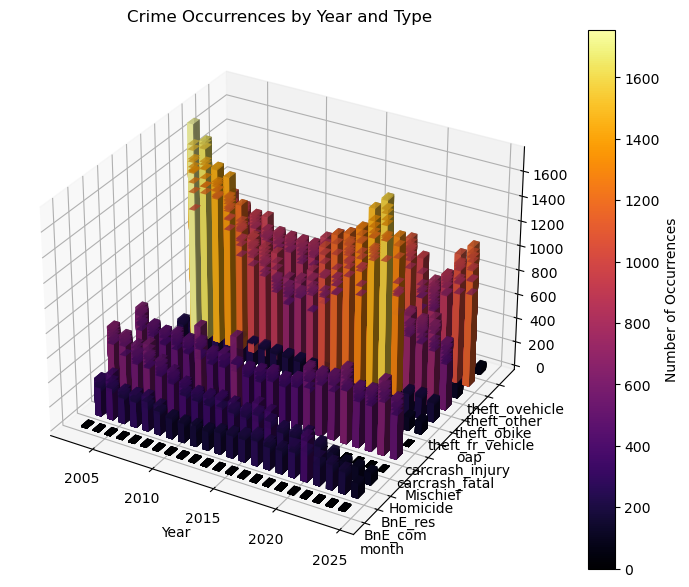

In [22]:
import matplotlib.cm as cm

years = crime_totals_melted['year']
crime_types = crime_totals_melted['crime_type']
occurrences = crime_totals_melted['occurrences']

# Encode crime types as numeric indices for positioning
crime_type_labels = crime_types.unique()
crime_type_indices = crime_types.replace({k: v for v, k in enumerate(crime_type_labels)})

norm = plt.Normalize(vmin=occurrences.min(), vmax=occurrences.max())

cmap = cm.inferno

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = cmap(norm(occurrences))  

ax.bar3d( x=years, y=crime_type_indices, z=np.zeros(len(occurrences)), dx=0.5, dy=0.5, dz=occurrences, color=colors, alpha=0.8)

ax.set_xlabel('Year')
#ax.set_ylabel('Crime Type')
#ax.set_zlabel('Occurrences')
ax.set_yticks(range(len(crime_type_labels)))
ax.set_yticklabels(crime_type_labels)
plt.title('Crime Occurrences by Year and Type')

mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(occurrences)
plt.colorbar(mappable, label='Number of Occurrences')

plt.show()

### The above plot shows we can seperate the data by type, with thefts as one group, and car crashes as another. The theft seem to follow a trend over the years (sinusoidal perhaps?). 
### This plot also shows that monthly trends sometimes follow the yearly trends but not always, so we should seperate the two. 

In [23]:
crime_yearly = crime_clean.pivot_table(
    index=['neighbourhood', 'year'],  
    columns='crime_type',             # Unique values in 'type_crime' become column names - want the full names here
    aggfunc='size',  
    fill_value=0   # if no value, let it be 0 instead of nan
)
crime_yearly = crime_yearly.reset_index()
crime_yearly.head()


crime_type,neighbourhood,year,Break and Enter Commercial,Break and Enter Residential/Other,Homicide,Mischief,Offence Against a Person,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury)
0,Arbutus Ridge,2003,33,140,1,90,22,134,171,10,91,0,9
1,Arbutus Ridge,2004,30,142,0,113,18,102,193,10,106,1,2
2,Arbutus Ridge,2005,28,120,0,107,21,80,216,7,76,0,5
3,Arbutus Ridge,2006,26,131,0,87,27,93,105,9,37,0,3
4,Arbutus Ridge,2007,32,104,0,70,26,78,77,8,39,0,2


In [24]:
crime_yearly.rename({'Break and Enter Commercial': 'BnE Commercial','Break and Enter Residential/Other':'BnE Residential'}, axis=1, inplace=True)

In [25]:
crime_yearly.to_pickle('crime_countbyyear.pkl')

In [26]:
crime_yearly = pd.read_pickle('crime_countbyyear.pkl')
crime_yearly.head()

crime_type,neighbourhood,year,BnE Commercial,BnE Residential,Homicide,Mischief,Offence Against a Person,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury)
0,Arbutus Ridge,2003,33,140,1,90,22,134,171,10,91,0,9
1,Arbutus Ridge,2004,30,142,0,113,18,102,193,10,106,1,2
2,Arbutus Ridge,2005,28,120,0,107,21,80,216,7,76,0,5
3,Arbutus Ridge,2006,26,131,0,87,27,93,105,9,37,0,3
4,Arbutus Ridge,2007,32,104,0,70,26,78,77,8,39,0,2
